[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/So-Cool/bLIMEy/master?filepath=HCML_2019)

# bLIMEy: Surrogate Prediction Explanations Beyond LIME #

This directory contains a Jupyter Notebook that can be used to reproduce the
results included in the Appendix of the
"*bLIMEy: Surrogate Prediction Explanations Beyond LIME*" paper published at
the *2019 Workshop on Human-Centric Machine Learning*
([HCML 2019](https://sites.google.com/view/hcml-2019)) held during the
33rd Conference on Neural Information Processing Systems (NeurIPS 2019),
Vancouver, Canada.

The manuscript is available on [arXiv](https://arxiv.org/abs/1910.13016).

To run the notebook (`bLIMEy.ipynb`) you need to install
`fat-forensics>=0.0.2`, `matplotlib` and `scikit-learn`. Additionally, the
`watermark` package is required for watermarking the notebook.
You can install these dependencies using the `requirements.txt` file
(included in this directory) by executing `pip install -r requirements.txt`.
Alternatively you can run it on Binder by following the Binder link above
(click on the *Binder* button).

## Abstract ##

Surrogate explainers of black-box machine learning predictions are of paramount
importance in the field of eXplainable Artificial Intelligence since they can
be applied to any type of data (images, text and tabular), are model-agnostic
and are post-hoc (i.e., can be retrofitted). The Local Interpretable
Model-agnostic Explanations (LIME) algorithm is often mistakenly unified with a
more general framework of surrogate explainers, which may lead to a belief that
it is the solution to surrogate explainability. In this paper we empower the
community to "build LIME yourself" (bLIMEy) by proposing a principled
algorithmic framework for building custom local surrogate explainers of
black-box model predictions, including LIME itself. To this end, we demonstrate
how to decompose the surrogate explainers family into algorithmically
independent and interoperable modules and discuss the influence of these
component choices on the functional capabilities of the resulting explainer,
using the example of LIME.

## BibTeX ##
```
@article{sokol2019blimey,
  title={b{LIME}y: {S}urrogate {P}rediction {E}xplanations {B}eyond {LIME}},
  author={Sokol, Kacper and Hepburn, Alexander and Santos-Rodriguez, Raul
          and Flach, Peter},
  journal={2019 Workshop on Human-Centric Machine Learning (HCML 2019) at the
           33rd Conference on Neural Information Processing Systems
           (NeurIPS 2019), Vancouver, Canada},
  note={arXiv preprint arXiv:1910.13016},
  url={https://arxiv.org/abs/1910.13016},
  year={2019}
}
```

## Import All the Necessary Modules ##
### Auxiliary Imports ###

In [27]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

import sklearn.datasets
import sklearn.preprocessing
import sklearn.tree

%matplotlib inline

### FAT Forensics Imports ###

In [2]:
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.data.augmentation as fatf_augmentation
import fatf.utils.kernels as fatf_kernels
import fatf.utils.distances as fatf_distances

import fatf

19-Oct-29 01:33:02 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


## Watermark the Notebook ##

In [3]:
%load_ext watermark
%watermark -v -p scipy,numpy,sklearn,matplotlib,fatf

CPython 3.7.1
IPython 7.3.0

scipy 1.3.0
numpy 1.16.4
sklearn 0.21.1
matplotlib 3.1.0
fatf 0.0.2


## Set Up the Random Seeds ##
Set up Python's and numpy's random seeds to guarantee reproducibility of the results.

In [4]:
random_seed = 42
fatf.setup_random_seed(random_seed)

19-Oct-29 01:33:02 fatf         INFO     Seeding RNGs using the input parameter.
19-Oct-29 01:33:02 fatf         INFO     Seeding RNGs with 42.


## Appendix A2: Comparison of Data Samplers for Tabular Data ##
### Prepare the Iris Data Set ###

We use the first two features of the Iris data set: 'sepal length (cm)' and 'sepal width (cm)', to facilitate 2-dimensional plotting of our experiments.

In [5]:
iris = fatf_datasets.load_iris()

iris_selected_features = [0, 1]

iris_target = iris['target'].astype(np.int16)
iris_target_names = iris['target_names']

iris_data = iris['data'][:, iris_selected_features]
iris_feature_names = iris['feature_names'][iris_selected_features]

print('Used feature names: {}.'.format(' and '.join(iris_feature_names)))

Used feature names: sepal length (cm) and sepal width (cm).


### Train a Predictive Model ###
Train a scikit-learn *Random Forest Classifier* on the first two features of the Iris data set and print out the *training set* accuracy.

In [6]:
clf_iris = RandomForestClassifier(n_estimators=50)
clf_iris.fit(iris_data, iris_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
iris_training_predictions = clf_iris.predict(iris_data)

iris_training_accuracy = sklearn.metrics.accuracy_score(
    iris_target, iris_training_predictions)

print('Training set *accuracy*: {:.3}.'.format(iris_training_accuracy))

Training set *accuracy*: 0.927.


### Plot the Training Data Set and the Decision Boundaries ###

In [8]:
colours_points = [plt.cm.Set1(i) for i in range(3)]
colours_predictions = [plt.cm.Pastel1(i) for i in range(3)]

x_min = iris_data[:, 0].min() - 2.3
x_max = iris_data[:, 0].max() + 1

y_min = iris_data[:, 1].min() - 0.5
y_max = iris_data[:, 1].max() + 1

grid_step = 0.01
grid_xx, grid_yy = np.meshgrid(
    np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

grid_prediction = clf_iris.predict(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])
grid_prediction = grid_prediction.reshape(grid_xx.shape)
grid_prediction = grid_prediction.astype(np.int16)

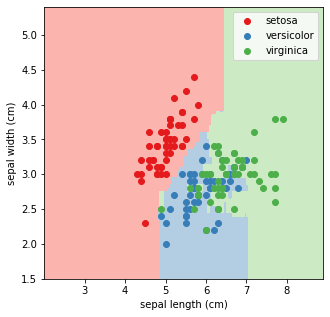

In [9]:
plt.figure(figsize=(5, 5))

plt.contourf(grid_xx, grid_yy, grid_prediction,
             levels=2, colors=colours_predictions)

for i in range(3):
    ix = np.where(iris_target == i)
    plt.scatter(iris_data[ix, 0], iris_data[ix, 1],
                label=iris_target_names[i],
                c=[colours_points[i]])

plt.xlabel(iris_feature_names[0])
plt.ylabel(iris_feature_names[1])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

plt.savefig('iris.pdf', dpi=300, transparent=True)

### Prepare the Sampling Algorithms ###

In [10]:
samplers_names = [
    'normal',
    'truncated_normal',
    'mixup',
    'normal_class_discovery'
]

samplers = [
    fatf_augmentation.NormalSampling(iris_data),
    fatf_augmentation.TruncatedNormalSampling(iris_data),
    fatf_augmentation.Mixup(iris_data, iris_target),
    fatf_augmentation.NormalClassDiscovery(
        iris_data, clf_iris.predict, classes_number=3,
        standard_deviation_init=0.20,
        standard_deviation_increment=0.10)
]

### Choose a Data Point and Sample Around It ###

In [11]:
data_point_index = 32
samples_number = 150

sampled_data = []
for sampler in samplers:
    sample = sampler.sample(
        iris_data[data_point_index, :],
        samples_number=samples_number)
    sampled_data.append(sample)

### Plot the Samples ###

Used sampler: normal.
Used sampler: truncated_normal.
Used sampler: mixup.
Used sampler: normal_class_discovery.


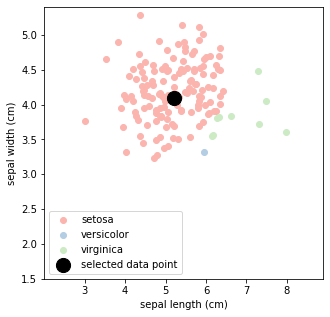

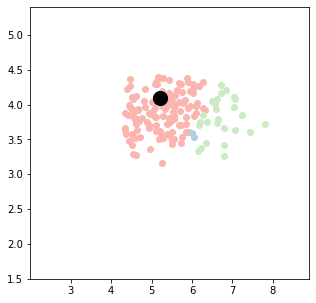

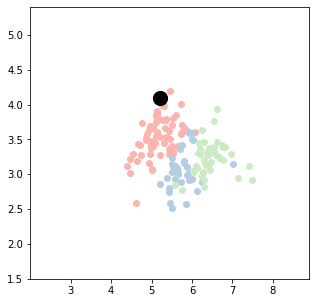

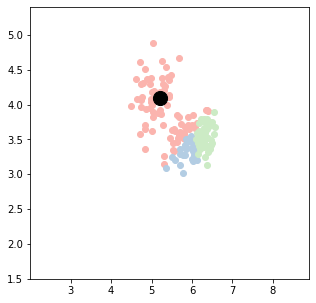

In [12]:
for i, name in enumerate(samplers_names):
    print('Used sampler: {}.'.format(name))
    
    plt.figure(figsize=(5, 5))

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    data = sampled_data[i]
    prediction = clf_iris.predict(data)
    
    for j in range(3):
        jx = np.where(prediction == j)
        
        # Only print the legend for the first figure
        label = iris_target_names[j] if not i else None
        plt.scatter(data[jx, 0], data[jx, 1], label=label,
                    c=[colours_predictions[j]])

    # Only print the legend for the first figure
    label = 'selected data point' if not i else None
    plt.scatter(iris_data[data_point_index][0],
                iris_data[data_point_index][1],
                c='k', s=200, label=label)

    # Only print the legend for the first figure
    if not i:
        plt.xlabel(iris_feature_names[0])
        plt.ylabel(iris_feature_names[1])
        plt.legend()
    
    filename = 'iris_sample_{}.pdf'.format(name)
    plt.savefig(filename, dpi=300, transparent=True)

## Appendix A3: Decision Tree-based Surrogate Explainer for Tabular Data ##
### Prepare the Two Moons Data Set ###

In [13]:
moons_scaler = sklearn.preprocessing.MinMaxScaler(
    feature_range=(0, 1))

moons_data, moons_target = sklearn.datasets.make_moons(
    n_samples=1000, noise=0.25)
moons_data = moons_scaler.fit_transform(moons_data)

### Train a Predictive Model ###
Train a scikit-learn *Random Forest Classifier* on the first two features of the Iris data set and print out the *training set* accuracy.

In [14]:
clf_moons = RandomForestClassifier(n_estimators=50)
clf_moons.fit(moons_data, moons_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
moons_training_predictions = clf_moons.predict(moons_data)

moons_training_accuracy = sklearn.metrics.accuracy_score(
    moons_target, moons_training_predictions)

print('Training set *accuracy*: {:.3}.'.format(moons_training_accuracy))

Training set *accuracy*: 0.999.


### Select a Data Point to Be Explained ###

In [16]:
data_point = np.array([0.25, 0.50])
data_point_target = 0

### Plot the Training Data Set and the Decision Boundaries ###

In [17]:
x_min = moons_data[:, 0].min()
x_max = moons_data[:, 0].max()
x_range = x_max - x_min

y_min = moons_data[:, 1].min()
y_max = moons_data[:, 1].max()
y_range = y_max - y_min

padding = 0.15

x_min -= x_range * padding
x_max += x_range * padding

y_min -= y_range * padding
y_max += y_range * padding

grid_step = 0.01
grid_xx, grid_yy = np.meshgrid(
    np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

grid_prediction = clf_moons.predict_proba(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])
# Get probabilities of the selected class
grid_prediction = grid_prediction[:, data_point_target]
grid_prediction = grid_prediction.reshape(grid_xx.shape)

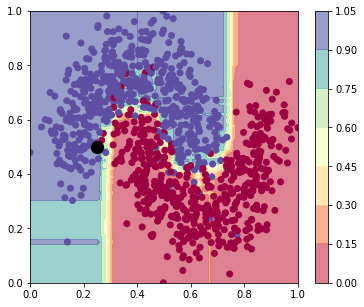

In [18]:
plt.figure(figsize=(6, 5))

cs = plt.contourf(grid_xx, grid_yy, grid_prediction,
                  cmap=plt.cm.Spectral, vmin=0, vmax=1,
                  alpha=0.6)
cbar = plt.colorbar(cs)

plt.scatter(moons_data[:, 0], moons_data[:, 1],
            c=moons_target, cmap=plt.cm.Spectral.reversed())

plt.scatter(data_point[0], data_point[1], c='k', s=150)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.savefig('two_moons.pdf', dpi=300, transparent=True)

### Build Surrogates ###

In [19]:
moons_local_samples_number = 1000

moons_sampler = fatf_augmentation.NormalSampling(moons_data)
moons_sampled_data = moons_sampler.sample(
    data_point, samples_number=moons_local_samples_number)

moons_sampled_data_prediction = clf_moons.predict_proba(
    moons_sampled_data)[:, data_point_target]

distance_normal = fatf_distances.euclidean_point_distance(
    data_point, moons_sampled_data)

# Kernel width is set to the default value in the LIME implementation
moons_kernel_width = 0.75 * np.sqrt(moons_sampled_data.shape[1])
moons_sampled_weights = fatf_kernels.exponential_kernel(
    distance_normal, width=moons_kernel_width)

#### Surroagate Ridge Regression ####

In [20]:
moons_ridge = Ridge(alpha=1, fit_intercept=True)
moons_ridge.fit(moons_sampled_data, moons_sampled_data_prediction,
                sample_weight=moons_sampled_weights)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [26]:
moons_ridge.coef_

array([-1.08909511,  0.69376231])

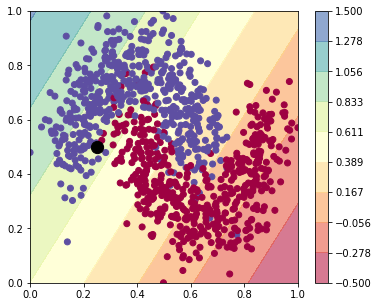

In [21]:
levels = np.linspace(-0.5, 1.5, 10)

ridge_prediction = moons_ridge.predict(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])   
ridge_prediction = ridge_prediction.reshape(grid_xx.shape)

plt.figure(figsize=(6, 5))

cs = plt.contourf(grid_xx, grid_yy, ridge_prediction,
                  cmap=plt.cm.Spectral, alpha=0.6,
                  levels=levels)
cbar = plt.colorbar(cs)

plt.scatter(moons_data[:, 0], moons_data[:, 1], c=moons_target,
            cmap=plt.cm.Spectral.reversed())
plt.scatter(data_point[0], data_point[1], c='k', s=150)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.savefig('two_moons_ridge.pdf', dpi=300, transparent=True)

#### Surroagate Decision Tree ####

In [22]:
moons_tree = DecisionTreeRegressor(max_depth=3)
moons_tree.fit(moons_sampled_data, moons_sampled_data_prediction,
               sample_weight=moons_sampled_weights)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

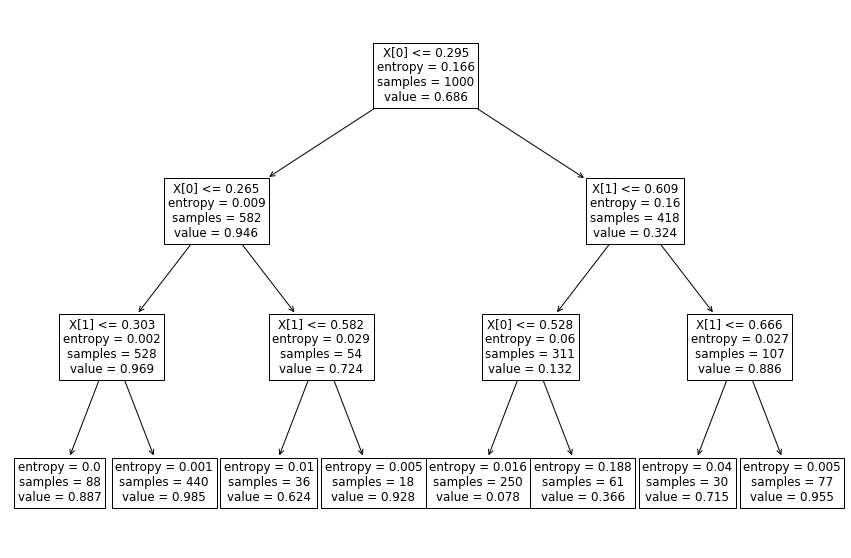

In [34]:
plt.figure(figsize=(15, 10))
moons_tree_text = sklearn.tree.plot_tree(moons_tree)

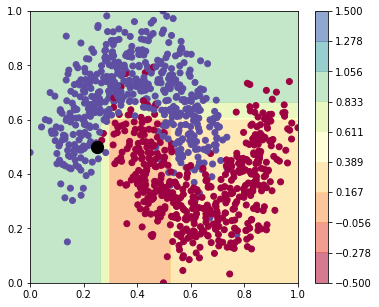

In [23]:
tree_prediction = moons_tree.predict(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])
tree_prediction = tree_prediction.reshape(
    grid_xx.shape)

plt.figure(figsize=(6, 5))

cs = plt.contourf(grid_xx, grid_yy, tree_prediction,
                  cmap=plt.cm.Spectral, alpha=0.6,
                  levels=levels)
cbar = plt.colorbar(cs)

plt.scatter(moons_data[:, 0], moons_data[:, 1], c=moons_target,
            cmap=plt.cm.Spectral.reversed())
plt.scatter(data_point[0], data_point[1], c='k', s=150)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.savefig('two_moons_tree.pdf', dpi=300, transparent=True)